# Assigment 6

## Upload your code (.ipynb) on Learn dropbox and submit pdfs of the code and the mathematical questions to Crowdmark.

## -----------------------------------------------------------------------------------------------------------

In [3]:
import matplotlib.pyplot as plt

# Numpy is useful for handling arrays and matrices.
import numpy as np
from scipy.sparse import coo_matrix
import time
from random import randrange as rnd
import sklearn
import sklearn.metrics
import random
import pandas as pd
from pathlib import Path
from imageio import imread
import time

In [36]:
initParams = {
    'lambda_': 0.001,
    'max_iter': 1000,
    'sigma': 1e-6,
    'delta': 1e-6,
    'k': 35000,
    'p': 0.09,
    'gamma': 0.001
}

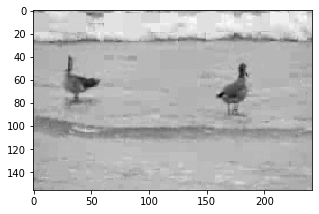

In [5]:
#load data
shape = (156, 242)
A = np.zeros((71, 156 * 242))
for i in range (1, 72):
    filename = 'JPEGS/birds/frame_' + str(i) + '.jpg'
    img = np.array(imread(filename)).flatten()
    A[i - 1] = img.T
A = A.T
plt.figure(1, figsize = (5, 5))
plt.imshow(np.reshape(A[:, 0], shape), cmap = 'gray')
plt.show()

## Rank-Sparsity 

## Question 1

Implement ADMM for the problem of separating a background image from foreground interference. Download the datasets at: http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz 

You will have to solve this problem:

$$
\begin{align*}
\mbox{minimize} & \ \|L\|_* + \gamma \|M\|_1 \\
\mbox{subj. to:} & \ L+M=A
\end{align*}
$$

where $\gamma>0$ is a parameter that you will have to tune. 

Use only the first dataset, birds, which contains 71 jpeg images each with 37752 gray-scale pixels. Form a matrix A of size 37752 x 71 with these images. 

When you are done, print the background image (that is, columns of the component L) for frames 1, 11, ..., 71. 

Note that this algorithm requires SVD. Computing the SVD in the usual way is very expensive for this dataset because the U matrix in SVD has size 37752 × 37752. You will have to utilize the "economy" SVD in https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.svd.html
or 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
by setting the option full_matrices = False.

Marks: 33.

In [10]:
class ADMM():
    def __init__(self):
        self.p = initParams['p']
        self.gamma = initParams['gamma']
        
    def __str__(self):
        return 'Alternating Direction Method of Multipliers'
    
    def objFunc(self, L, M, Y, A):
        LNorm = np.linalg.norm(L, ord = 'fro')
        MNorm = np.linalg.norm(M, 1)
        return LNorm + self.gamma * MNorm 
    
    def LProx(self, M, A, Y):
        p = self.p
        z = -M + A - (1 / p) * Y
        u, s, vT = np.linalg.svd(z, full_matrices = False)
        
        s = np.maximum(s - 1/p, 0)
        sDense = np.zeros((u.shape[1], vT.shape[0]))
        sDense[:len(s), :len(s)] = np.diag(s)
        
        LNext = u @ sDense @ vT
        return LNext
    
    def MProx(self, L, A, Y):
        p = self.p
        gamma = self.gamma
        u = -L + A - (1 / p) * Y
        MNext = np.zeros_like(A)
        
        MNext[u >= gamma/p] = u[u >= gamma/p] - gamma/p
        MNext[np.abs(u) <= gamma/p] = 0
        MNext[u <= -gamma/p] = u[u <= -gamma/p] + gamma/p
        
        return MNext
    
    def admm(self, M, A, Y):
        max_iters = initParams['max_iter']
        for i in range(max_iters):
            if (i % 100 == 0): print('Iteration', i + 1, 'of', max_iters)
            L = self.LProx(M, A, Y)
            M = self.MProx(L, A, Y)
            Y = Y + self.p * (L + M - A)
        return L, M

In [18]:
M0 = np.random.rand(A.shape[0], A.shape[1])
Y0 = np.random.rand(A.shape[0], A.shape[1])
admm = ADMM()
start = time.time()
L, M = admm.admm(M0, A, Y0)
print('Done', initParams['max_iter'], 'iterations of', admm.__str__(), 'in', time.time() - start, 's')

Iteration 1 of 1000
Iteration 101 of 1000
Iteration 201 of 1000
Iteration 301 of 1000
Iteration 401 of 1000
Iteration 501 of 1000
Iteration 601 of 1000
Iteration 701 of 1000
Iteration 801 of 1000
Iteration 901 of 1000
Done 1000 iterations of Alternating Direction Method of Multipliers in 207.82634019851685 s


Alternating Direction Method of Multipliers


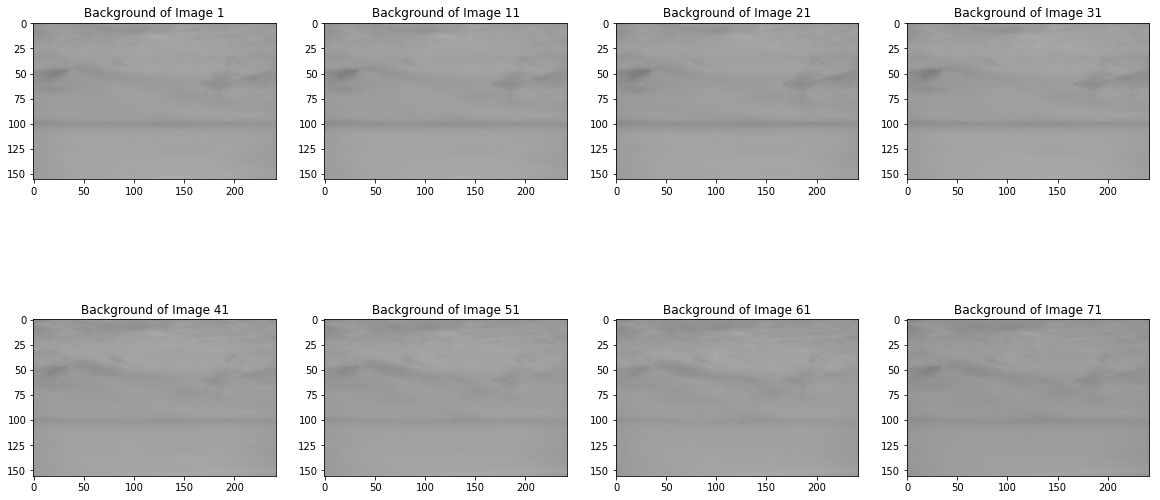

In [12]:
print(admm.__str__())

f, axarr = plt.subplots(2, 4, figsize = (20, 10))
axarr[0,0].imshow(np.reshape(L[:, 0], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,0].title.set_text('Background of Image 1')

axarr[0,1].imshow(np.reshape(L[:, 10], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,1].title.set_text('Background of Image 11')

axarr[0,2].imshow(np.reshape(L[:, 20], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,2].title.set_text('Background of Image 21')

axarr[0,3].imshow(np.reshape(L[:, 30], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[0,3].title.set_text('Background of Image 31')

axarr[1,0].imshow(np.reshape(L[:, 40], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,0].title.set_text('Background of Image 41')

axarr[1,1].imshow(np.reshape(L[:, 50], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,1].title.set_text('Background of Image 51')

axarr[1,2].imshow(np.reshape(L[:, 60], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,2].title.set_text('Background of Image 61')

axarr[1,3].imshow(np.reshape(L[:, 70], shape), cmap = 'gray', vmin = 0, vmax = 255)
axarr[1,3].title.set_text('Background of Image 71')

plt.show()

## Robust Linear Regression

## Question 2

Implement AM-RR (alternating minimization for robust regresion) on the same dataset as Q1. Form a matrix X whose columns are the first 70 bird images. Form a vector y that is the 71st image. Then try to fit $$y\approx Xw $$ using the Robust Linear Regression problem. 

Illustrate the following two plots. The first plot should show the image that was not covered by set S (S is an output of AM-RR). In other words, y(S^c), where S^c is the complement of S with respect to the set of all pixels. Pixels in S should be set to white (255, when the grey scale image is from 0 to 255) in this image. 

The second plot should show the image indexed by S, in other words, X(S,:)w. Fill in the entries not indexed by S 
to white. 

Marks: 33.

In [69]:
class AMRR():
    def __init__(self, y, w1):
        self.n = y.shape[0]
        self.k = 2000#initParams['k'] # 11000
        self.alpha = 0.1 / self.n
        self.y = y
        self.w1 = w1
        self.S1 = np.arange(1, self.n - self.k)
        
    def __str__(self):
        return 'Alternating Minimization for Robust Regression'
    
    def objFunc(self, X, w, S):
        y = self.y
        return 0.5 * np.linalg.norm(y[S] - X[S] @ w) ** 2
    
    def gradW(self, X, w, S):
        y = self.y
        sigma = X[S] @ w - y[S]
        return np.sum((sigma * X[S].T).T, axis = 0)
        
    def step4(self, X, w):
        n = self.n
        k = self.k
        y = self.y
        return np.argsort((y - X @ w) ** 2)[: n - k + 1]
    
    def amrr(self, X, dataW, dataS):
        n = self.n
        max_iters = initParams['max_iter']
        alpha = self.alpha
        y = self.y
        w = self.w1
        S = self.S1
        
        for i in range(max_iters):
            if (i % 100 == 0): print('Iteration', i + 1, 'of', max_iters)
            gradW = self.gradW(X, w, S)
            w -= alpha * gradW
            S = self.step4(X, w)
            dataW.append(w)
            dataS.append(S)
        return w, S     

In [70]:
dataW = []
dataS = []
X = A[:, : 70]
y = A[:, 70]
w1 = np.zeros(X.shape[1])
amrr = AMRR(y, w1)
start = time.time()
w, S = amrr.amrr(X, dataW, dataS)
print('Done', initParams['max_iter'], 'iterations of', amrr.__str__(), 'in', time.time() - start, 's')

Iteration 1 of 1000
Iteration 101 of 1000
Iteration 201 of 1000
Iteration 301 of 1000
Iteration 401 of 1000
Iteration 501 of 1000
Iteration 601 of 1000
Iteration 701 of 1000
Iteration 801 of 1000
Iteration 901 of 1000
Done 1000 iterations of Alternating Minimization for Robust Regression in 41.839574098587036 s


Alternating Minimization for Robust Regression


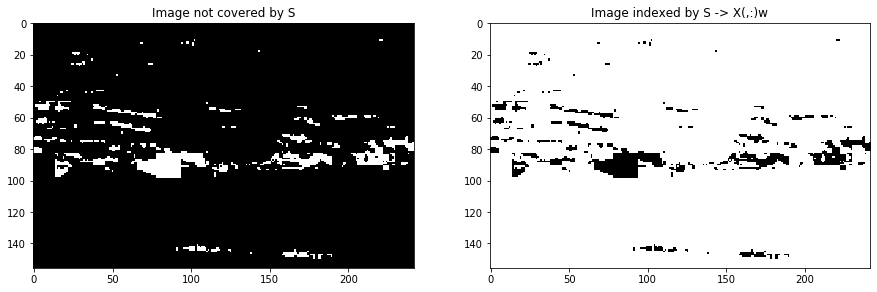

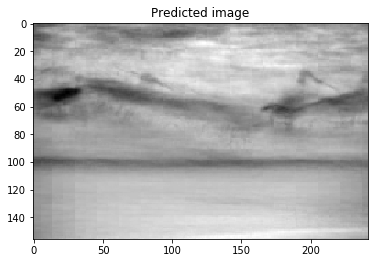

In [71]:
y = X @ w
ySc = np.copy(y) # Not Covered
yS = np.copy(y)  # Covered

for i in range(y.shape[0]):
    if i not in S:
        ySc[i] = 255
        yS[i] = 0
    else:
        ySc[i] = 0
        yS[i] = 255
        
# for i in S:
#     yS[i] = 1
    
ySc = np.reshape(ySc, shape)
yS = np.reshape(yS, shape)

print(amrr.__str__())
f, axarr = plt.subplots(1, 2, figsize = (15, 20))

axarr[0].imshow(ySc, cmap = 'gray')
axarr[0].title.set_text('Image not covered by S')

axarr[1].imshow(yS, cmap = 'gray')
axarr[1].title.set_text('Image indexed by S -> X(,:)w')

plt.show()

plt.imshow(np.reshape(y, shape), cmap = 'gray')
plt.title('Predicted image')
plt.show()

## Nonnegative matrix factorization

Consider the nonnegative matrix factorization problem. For this problem, we showed that the modified multiplicative updates algorithm satisfies the nonnegativity constraints at each iteration. Consider now the nonnegative sparse coding problem:
$$
\begin{align*}
\mbox{minimize}_{W,H} &  \ F(W,H):= \frac{1}{2}\| WH-X\|_F^2 + \lambda \|H\|_1\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j,
\end{align*}
$$
where 
$$
\|H\|_1 = \sum_{i,j} |H_{ij}|.
$$
and $\lambda \ge 0$ is a parameter that controls the effect of the l1-norm. This problem is called sparse coding because the l1-norm forces a lot of weights in matrix $H$ to become zero.

Dataset consists of 400 faces


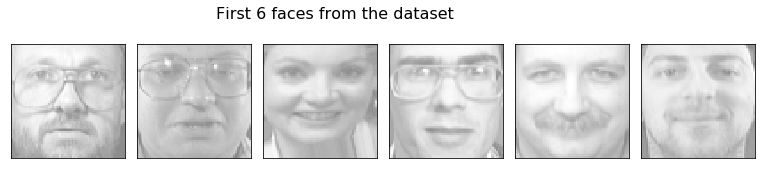

In [74]:
# This piece of code is for loading data and visualizing 
# the first 6 images in the dataset.

# Useful packages for loading the data and plotting
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

# Useful function for plotting
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.12, 0.05, 0.99, 0.75, 0.04, 0.)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

# Store the vectorized images. Each image has dimensions 64 x 64.
faces = dataset.data

print("Dataset consists of %d faces" % len(faces))
    
plot_gallery("First 6 faces from the dataset", faces[:6], 6, 1)

## Question 3

Show that the modified multiplicative updates algorithm for the above nonnegative sparse coding problem also satisfies the nonnegative constraints at each iteration. 

Marks: 5

See attached

## Question 4

Use the face dataset, see Assigment 5. Set parameter $r=6$ in the nonnegative factorization problem. Plot $\frac{1}{2}\| WH-X\|_F^2$ as $\lambda$ increases.

Marks: 12

In [75]:
class NonNegMatFac():
    def __init__(self, lambda_, data):
        self.lambda_ = lambda_
        self.sigma = initParams['sigma']
        self.delta = initParams['delta']
        self.X = data.T
    
    def __str__(self):
        return 'Non-negative Matrix Factorization'
    
    def objFunc(self, W, H):
        X = self.X
        return 0.5 * np.linalg.norm(W @ H - X, ord = 'fro') ** 2 + self.lambda_ * np.linalg.norm(H, 1)
    
    def gradH(self, W, H):
        X = self.X
        temp = W.T @ (W @ H - X)
        return temp + np.full(temp.shape, self.lambda_)
        
    def gradW(self, W, H):
        X = self.X
        return (W @ H - X) @ H.T
    
    def HBar(self, W, H):
        gradH = self.gradH(W, H)
        HBar = np.where(gradH >= 0, H, np.maximum(H, self.sigma * np.ones((H.shape))))
        return HBar
    
    def WBar(self, W, H):
        gradW = self.gradW(W, H)
        WBar = np.where(gradW >= 0, W, np.maximum(W, self.sigma * np.ones((W.shape))))
        return WBar
    
    def bars(self, W, H):
        HBar = self.HBar(W, H)
        WBar = self.WBar(W, H)
        return HBar, WBar
    
    def normalize(self, r, W, H):
        S = np.eye(r) / np.sum(W, 0)
        W = W @ S
        H = np.linalg.inv(S) @ H
        return W, H

In [76]:
def nonNegMatFac(lambda_, data, r = 6):
    m, n = data.T.shape
    max_iters = initParams['max_iter']
    nnmf = NonNegMatFac(lambda_, data)
    W = np.random.uniform(0, 1, size = (m, r))
    H = np.random.uniform(0, 1, size = (r, n))
    delta = initParams['delta']
    
    for i in range(max_iters):
        HBar = nnmf.HBar(W, H)
        H = H - np.divide(HBar, ((W.T @ W @ HBar) + delta)) * nnmf.gradH(W, H)
        
        WBar = nnmf.WBar(W, H)
        W = W - np.divide(WBar, ((WBar @ H @ HBar.T) + delta)) * nnmf.gradW(W, H)
        
        #Normalize
        W, H = nnmf.normalize(r, W, H)
    return W, H

In [79]:
WHData = []
lambda_list = np.power(10, np.linspace(-6, -1, 50))
start = time.time()
for i in range(len(lambda_list)):
    if (i % 5 == 0):
        print('Lambda =', lambda_list[i])
        print('Starting number', i + 1, 'of', len(lambda_list))
    
    W, H = nonNegMatFac(lambda_list[i], faces)
    WHData.append(0.5 * np.linalg.norm(W @ H - faces.T, ord = 'fro') ** 2)
    
    if (i % 5 == 0): 
        print('Computed W and H for lambda Value:', lambda_list[i])
        print()
print('Done computing W and H for all', len(lambda_list), 'lambdas in', time.time() - start, 's')

Lambda = 1e-06
Starting number 1 of 50
Computed W and H for lambda Value: 1e-06

Lambda = 3.2374575428176467e-06
Starting number 6 of 50
Computed W and H for lambda Value: 3.2374575428176467e-06

Lambda = 1.0481131341546853e-05
Starting number 11 of 50
Computed W and H for lambda Value: 1.0481131341546853e-05

Lambda = 3.39322177189533e-05
Starting number 16 of 50
Computed W and H for lambda Value: 3.39322177189533e-05

Lambda = 0.00010985411419875583
Starting number 21 of 50
Computed W and H for lambda Value: 0.00010985411419875583

Lambda = 0.00035564803062231287
Starting number 26 of 50
Computed W and H for lambda Value: 0.00035564803062231287

Lambda = 0.0011513953993264481
Starting number 31 of 50
Computed W and H for lambda Value: 0.0011513953993264481

Lambda = 0.0037275937203149418
Starting number 36 of 50
Computed W and H for lambda Value: 0.0037275937203149418

Lambda = 0.012067926406393288
Starting number 41 of 50
Computed W and H for lambda Value: 0.012067926406393288

Lamb

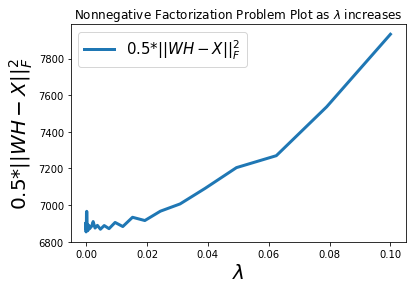

In [92]:
plt.plot(lambda_list, WHData, label = r"0.5*$\||WH-X||^2_F$", linewidth = 3)
plt.legend(fontsize = 15)
plt.xlabel("$\lambda$", fontsize = 20)
plt.ylabel(r"0.5*$\||WH-X||^2_F$", fontsize = 20)
# plt.xscale('log')
plt.title('Nonnegative Factorization Problem Plot as $\lambda$ increases')
plt.show()

## Question 5

Choose a $\lambda$ and extract the features matrix $W$ by solving the nonnegative matrix factorization problem. Report the 6 features of the faces dataset, i.e., the 6 columns of matrix $W$. You can report the features by visualizing them in a similar way to the above example.

Marks: 12

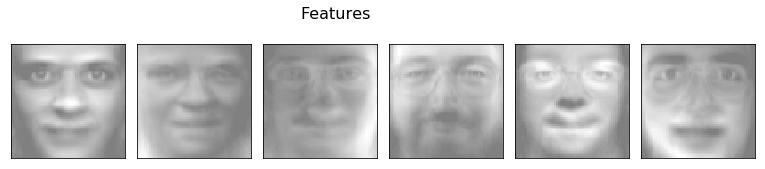

In [81]:
W, H = nonNegMatFac(initParams['lambda_'], faces)
plot_gallery("Features", W.T[:6], 6, 1)

## Question 6

For your chosen $\lambda$, which are the most important features of the first 6 faces? Provide the code on how to obtain the most important features.

Marks: 5

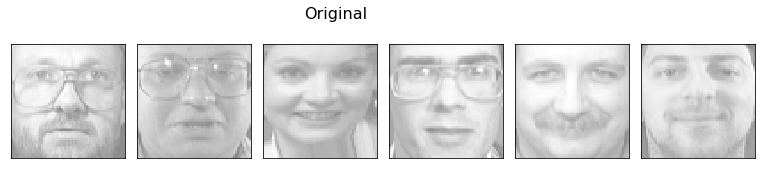

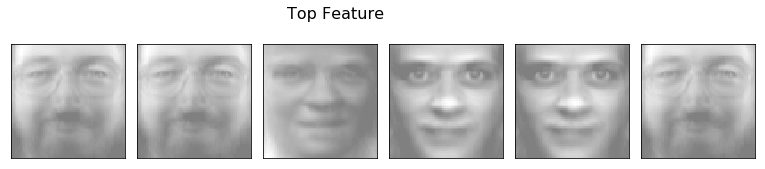

In [82]:
first6 = faces[: 6]
topFeatures = []
for i in range(6):
    topFeatures.append(np.argsort(-H[:,i])[:1])
topFeatures = np.asarray(topFeatures)
first6 = np.append(first6, W.T[topFeatures.T[0]], 0)
for i in range(2):
    if (i == 0):
        plot_gallery('Original', first6[0: (i + 1) * 6], 6, 1)
    else:
        plot_gallery('Top Feature', first6[i * 6: (i + 1) * 6], 6, 1)